In [1]:
!pip install causalml
!pip install pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB

In [2]:
import pandas as pd
import numpy as np
import torch
import logging
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.torch import CEVAE
from causalml.inference.tf import DragonNet
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import plot_gain, auuc_score
from lightgbm import LGBMRegressor


In [3]:

import logging
import torch
from pyro.contrib.cevae import CEVAE as CEVAEModel

from causalml.inference.meta.utils import convert_pd_to_np

pyro_logger = logging.getLogger("pyro")
pyro_logger.setLevel(logging.DEBUG)
if pyro_logger.handlers:
    pyro_logger.handlers[0].setLevel(logging.DEBUG)


class CEVAE:
    def __init__(
        self,
        outcome_dist="studentt",
        latent_dim=20,
        hidden_dim=200,
        num_epochs=50,
        num_layers=3,
        batch_size=100,
        learning_rate=1e-3,
        learning_rate_decay=0.1,
        num_samples=1000,
        weight_decay=1e-4,
    ):
        """
        Initializes CEVAE.

            Args:
                outcome_dist (str): Outcome distribution as one of: "bernoulli" , "exponential", "laplace", "normal",
                                    and "studentt"
                latent_dim (int) : Dimension of the latent variable
                hidden_dim (int) : Dimension of hidden layers of fully connected networks
                num_epochs (int): Number of training epochs
                num_layers (int): Number of hidden layers in fully connected networks
                batch_size (int): Batch size
                learning_rate (int): Learning rate
                learning_rate_decay (float/int): Learning rate decay over all epochs; the per-step decay rate will
                                                 depend on batch size and number of epochs such that the initial
                                                 learning rate will be learning_rate and the
                                                 final learning rate will be learning_rate * learning_rate_decay
                num_samples (int) : Number of samples to calculate ITE
                weight_decay (float) : Weight decay
        """
        self.outcome_dist = outcome_dist
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_epochs = num_epochs
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.num_samples = num_samples
        self.weight_decay = weight_decay

    def fit(self, X, treatment, y, p=None):
        """
        Fits CEVAE.

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
        """
        X, treatment, y = convert_pd_to_np(X, treatment, y)

        self.cevae = CEVAEModel(
            outcome_dist=self.outcome_dist,
            feature_dim=X.shape[-1],
            latent_dim=self.latent_dim,
            hidden_dim=self.hidden_dim,
            num_layers=self.num_layers,
        )

        self.cevae.fit(
            x=torch.tensor(X, dtype=torch.float),
            t=torch.tensor(treatment, dtype=torch.float),
            y=torch.tensor(y, dtype=torch.float),
            num_epochs=self.num_epochs,
            batch_size=self.batch_size,
            learning_rate=self.learning_rate,
            learning_rate_decay=self.learning_rate_decay,
            weight_decay=self.weight_decay,
        )

    def predict(self, X, treatment=None, y=None, p=None):
        """
        Calls predict on fitted DragonNet.

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
        Returns:
            (np.ndarray): Predictions of treatment effects.
        """
        return (
            self.cevae.ite(
                torch.tensor(X, dtype=torch.float),
                num_samples=self.num_samples,
                batch_size=self.batch_size,
            )
            # .cpu()
            .numpy()
        )

    def fit_predict(self, X, treatment, y, p=None):
        """
        Fits the CEVAE model and then predicts.

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
        Returns:
            (np.ndarray): Predictions of treatment effects.
        """
        self.fit(X, treatment, y)
        return self.predict(X)

In [4]:
df_raw = pd.DataFrame()
for i in range(1, 10):
    url = f"""https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_{i}.csv"""
    data= pd.read_csv(url, header = None)
    df_raw = pd.concat([data, df_raw])
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]
df_raw.columns = cols

# Deep Learning 학습을 위해 100배 복제
replications = 100
df = pd.concat([df_raw]*replications, ignore_index=True).reset_index(drop=True)
binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
contfeats = [i for i in range(25) if i not in binfeats]
perm = binfeats + contfeats
df = df.reset_index(drop=True)

# 딥러닝 학습용 (대용량 복제 데이터)
X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1
               else d['y_cfactual'] - d['y_factual'],
               axis=1).reset_index(drop=True)
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr]

# 메타러너 학습 및 예측용 데이터 셋 (원본 크기)
X_raw_features = df_raw[perm].values
treatment_raw = df_raw['treatment'].values
y_raw = df_raw['y_factual'].values
y_cf_raw = df_raw['y_cfactual'].values
tau_raw = df_raw.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1
               else d['y_cfactual'] - d['y_factual'],
               axis=1).reset_index(drop=True)
itr_raw, ite_raw = train_test_split(np.arange(X_raw_features.shape[0]), test_size=0.2, random_state=1)
X_train_raw, treatment_train_raw, y_train_raw, y_cf_train_raw, tau_train_raw = X_raw_features[itr_raw], treatment_raw[itr_raw], y_raw[itr_raw], y_cf_raw[itr_raw], tau_raw[itr_raw]
X_val, treatment_val, y_val, y_cf_val, tau_val = X_raw_features[ite_raw], treatment_raw[ite_raw], y_raw[ite_raw], y_cf_raw[ite_raw], tau_raw[ite_raw]

In [ ]:

try:
    p_model = ElasticNetPropensityModel()
    p_model.fit(X_train_raw, treatment_train_raw)
    p_train = p_model.predict(X_train_raw).ravel()
    p_val   = p_model.predict(X_val).ravel()
except Exception:
    from sklearn.linear_model import LogisticRegression
    ps = LogisticRegression(max_iter=2000, solver="lbfgs")
    ps.fit(X_train_raw, treatment_train_raw)
    p_train = ps.predict_proba(X_train_raw)[:,1]
    p_val   = ps.predict_proba(X_val)[:,1]

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from lightgbm import LGBMRegressor

# S
s_learner = BaseSRegressor(LGBMRegressor(verbose=-1))
s_learner.fit(X_train_raw, treatment_train_raw, y_train_raw)
s_ite_val = np.asarray(s_learner.predict(X_val)).ravel()

# T
t_learner = BaseTRegressor(LGBMRegressor(verbose=-1))
t_learner.fit(X_train_raw, treatment_train_raw, y_train_raw)
t_ite_val = np.asarray(t_learner.predict(X_val)).ravel()

# X
x_learner = BaseXRegressor(LGBMRegressor(verbose=-1))
x_learner.fit(X_train_raw, treatment_train_raw, y_train_raw, p=p_train)
x_ite_val = np.asarray(x_learner.predict(X_val, p=p_val)).ravel()

# R
r_learner = BaseRRegressor(LGBMRegressor(verbose=-1))
r_learner.fit(X_train_raw, treatment_train_raw, y_train_raw, p=p_train)
r_ite_val = np.asarray(r_learner.predict(X_val, p=p_val)).ravel()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/v

In [ ]:


# cevae model settings
outcome_dist = "normal"
latent_dim = 20
hidden_dim = 200
num_epochs = 5
batch_size = 1000 * 2
learning_rate = 0.001
learning_rate_decay = 0.01
num_layers = 2



cevae = CEVAE(outcome_dist=outcome_dist,
              latent_dim=latent_dim,
              hidden_dim=hidden_dim,
              num_epochs=num_epochs,
              batch_size=batch_size,
              learning_rate=learning_rate,
              learning_rate_decay=learning_rate_decay,
              num_layers=num_layers

              )





# fit (2분))
losses = cevae.fit(
    X=torch.tensor(X_train, dtype=torch.float),
    treatment=torch.tensor(treatment_train, dtype=torch.float),
    y=torch.tensor(y_train, dtype=torch.float)
)


# predict (2분)
cevae_ite_train = cevae.predict(X_train_raw) #.cpu()
cevae_ite_val = cevae.predict(X_val)

cevae_ate_train = cevae_ite_train.mean()
cevae_ate_val = cevae_ite_val.mean()
print(cevae_ate_train, cevae_ate_val)



/tmp/ipython-input-1348207337.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(X, dtype=torch.float),
/tmp/ipython-input-1348207337.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t=torch.tensor(treatment, dtype=torch.float),
/tmp/ipython-input-1348207337.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(y, dtype=torch.float),
INFO:pyro.contrib.cevae:Training with 269 minibatches per epoch
DEBUG:pyro.contrib.cevae:step     0 loss = 472.882
DEBUG:pyro.contrib.cevae:step   100 loss = 36.6372
DEBUG:p

3.588019 3.2835095


In [ ]:
# help(DragonNet)

Help on class DragonNet in module causalml.inference.tf.dragonnet:

class DragonNet(builtins.object)
 |  DragonNet(neurons_per_layer=200, targeted_reg=True, ratio=1.0, val_split=0.2, batch_size=64, epochs=100, learning_rate=1e-05, momentum=0.9, reg_l2=0.01, use_adam=True, adam_epochs=30, adam_learning_rate=0.001, loss_func=<function dragonnet_loss_binarycross at 0x7c6310022520>, verbose=True)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, neurons_per_layer=200, targeted_reg=True, ratio=1.0, val_split=0.2, batch_size=64, epochs=100, learning_rate=1e-05, momentum=0.9, reg_l2=0.01, use_adam=True, adam_epochs=30, adam_learning_rate=0.001, loss_func=<function dragonnet_loss_binarycross at 0x7c6310022520>, verbose=True)
 |      Initializes a Dragonnet.
 |  
 |  fit(self, X, treatment, y, p=None)
 |      Fits the DragonNet model.
 |      
 |      Args:
 |          X (np.matrix or np.array or pd.Dataframe): a feature matrix
 |          treatment (np.array or pd.Series): a treatment vec

In [ ]:

dragonnet = DragonNet()

dragonnet.fit(X_train_raw, treatment_train_raw, y_train_raw) #X_train, treatment_train, y_train으로 학습하면 NAN으로 나옴 이유를모르겠음

# --- FINAL CORRECTED PREDICTION STEP ---

# predict 메소드에서 반환된 (5378, 4) 배열을 받음

pred_val = dragonnet.predict(X_val)

# ITE = y1(처방 O 결과) - y0(처방 X 결과)


dragonnet_ite_val = pred_val[:,1] - pred_val[:,0]

# ---------------------------------------

dragonnet_ate = dragonnet_ite_val.mean()




Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - binary_classification_loss: 36.9574 - loss: 28768.4355 - regression_loss: 14359.7090 - track_epsilon: 0.0016 - treatment_accuracy: 0.7170 - val_binary_classification_loss: 32.3219 - val_loss: 22722.5703 - val_regression_loss: 11383.7803 - val_track_epsilon: 0.0038 - val_treatment_accuracy: 0.8058 - learning_rate: 0.0010
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - binary_classification_loss: 31.6106 - loss: 22240.2344 - regression_loss: 11098.8574 - track_epsilon: 0.0034 - treatment_accuracy: 0.8146 - val_binary_classification_loss: 33.7119 - val_loss: 23094.7754 - val_regression_loss: 11565.7480 - val_track_epsilon: 0.0012 - val_treatment_accuracy: 0.8058 - learning_rate: 0.0010
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - binary_classification_loss: 32.5287 - loss: 24857.9492 - regression_loss: 12408.7588 - track_epsilon: 0.0015 - treatment_accuracy: 0.8036 - val_binary_classification_loss: 31.2152 - val_loss: 22683

/tmp/ipython-input-1103823829.py:32: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  'tau': tau_val.ravel(),                 # IHDP 정답 ITE


검증 데이터셋 성능 비교:
                ATE       MAE      AUUC
S          4.423512  4.887094  0.626410
T          4.416113  5.670750  0.583601
X          4.545114  4.842928  0.623546
R          1.196797  6.331547  0.534687
CEVAE      3.283509  7.127680  0.525123
DragonNet  5.058099  5.132709  0.698876
actual     4.559598       NaN       NaN


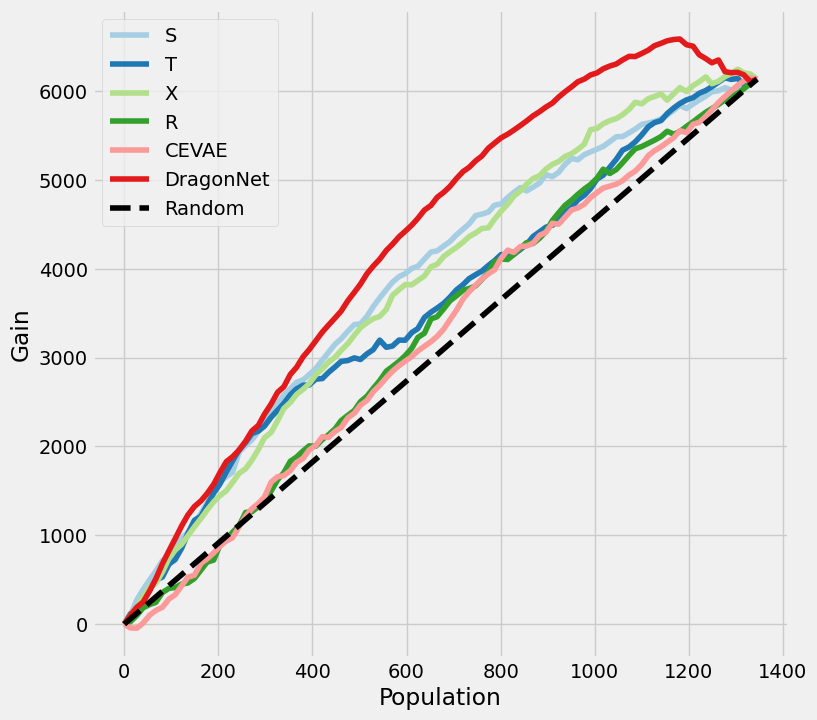

In [10]:
# # ---------------------------------------------------------------------------
# df_preds_train = pd.DataFrame({
#     'S': s_ite_train.ravel(), 'T': t_ite_train.ravel(), 'X': x_ite_train.ravel(),
#     'R': r_ite_train.ravel(), 'CEVAE': cevae_ite_val.ravel(), 'DragonNet': dragonnet_ite_train.ravel(),
#     'tau': tau_train_raw.ravel(), 'w': treatment_train_raw.ravel(), 'y': y_train_raw.ravel()
# })

# df_result_train = pd.DataFrame({
#     'ATE': [s_ate, t_ate, x_ate, r_ate, cevae_ate_train, dragonnet_ate, tau_train_raw.mean()]
# }, index=['S', 'T', 'X', 'R', 'CEVAE', 'DragonNet', 'actual'])

# mae_predictions = [s_ite_train, t_ite_train, x_ite_train, r_ite_train, cevae_ite_train, dragonnet_ite_train]
# mae_scores = [mean_absolute_error(tau_train_raw, p) for p in mae_predictions]
# df_result_train['MAE'] = mae_scores + [None]

# auuc_scores = auuc_score(df_preds_train, outcome_col='y', treatment_col='w')
# df_result_train['AUUC'] = pd.Series(auuc_scores)

# print("학습 데이터셋 성능 비교:")
# print(df_result_train)

# plot_gain(df_preds_train, outcome_col='y', treatment_col='w')

# 5) 검증셋용 테이블 생성
df_preds_val = pd.DataFrame({
    'S': s_ite_val,
    'T': t_ite_val,
    'X': x_ite_val,
    'R': r_ite_val,
    'CEVAE': cevae_ite_val,
    'DragonNet': dragonnet_ite_val,
    'tau': tau_val.ravel(),                 # IHDP 정답 ITE
    'w': treatment_val.ravel(),             # 실제 처리여부
    'y': y_val.ravel(),                     # 실제 결과
})

# 6) 지표 계산 (검증셋 기준)
def ate(v):  return float(np.mean(v))
def mae(p,t): return float(np.mean(np.abs(p - t)))

df_result_val = pd.DataFrame(index=['S','T','X','R','CEVAE','DragonNet','actual'])

# ATE는 예측 ITE 평균으로 통일(누수 방지)
df_result_val['ATE'] = [
    ate(s_ite_val), ate(t_ite_val), ate(x_ite_val), ate(r_ite_val),
    ate(cevae_ite_val), ate(dragonnet_ite_val), ate(tau_val)
]

# MAE는 tau_val과 비교 (actual은 없음)
mae_list = [
    mae(s_ite_val, tau_val), mae(t_ite_val, tau_val),
    mae(x_ite_val, tau_val), mae(r_ite_val, tau_val),
    mae(cevae_ite_val, tau_val), mae(dragonnet_ite_val, tau_val)
]
df_result_val['MAE'] = mae_list + [None]

# AUUC: 반드시 검증셋 df로 계산
auuc_scores = auuc_score(df_preds_val, outcome_col='y', treatment_col='w')
df_result_val['AUUC'] = pd.Series(auuc_scores)

print("검증 데이터셋 성능 비교:")
print(df_result_val)

# 7) 이득곡선(검증셋)
plot_gain(df_preds_val, outcome_col='y', treatment_col='w')

In [19]:
# 예측값 중, 차이가 가장 큰 항목 확인
diff = s_ite_val.ravel() - dragonnet_ite_val.ravel()
diff_max_idx = diff.argmax()
diff_max_idx

np.int64(101)

In [24]:
# X_train_raw #, treatment_train_raw, y_train_raw, y_cf_train_raw, tau_train_raw
q1 = pd.DataFrame(X_val)
q2 = pd.DataFrame(treatment_val, columns=['treatment'])
q3 = pd.DataFrame(y_val.ravel(), columns=['y_factual'])
q4 = pd.DataFrame(tau_val.ravel(), columns=['tau'])

df_val = pd.concat([q1, q2, q3, q4], axis=1).reset_index(drop=True)
df_val['s_learner'] = s_ite_val.ravel()
df_val['dragonnet'] = dragonnet_ite_val.ravel()

# 차이가 가장 큰 샘플 확인
diff = df_val['dragonnet'] - df_val['s_learner']
diff_max_idx = diff.to_numpy().argmax()
df_val.iloc[diff_max_idx]

/tmp/ipython-input-2506109681.py:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  q4 = pd.DataFrame(tau_val.ravel(), columns=['tau'])


,319
0,1.000000
1,0.000000
2,1.000000
3,0.000000
4,0.000000
5,1.000000
6,0.000000
7,1.000000
8,0.000000
9,1.000000


## 결과 해석

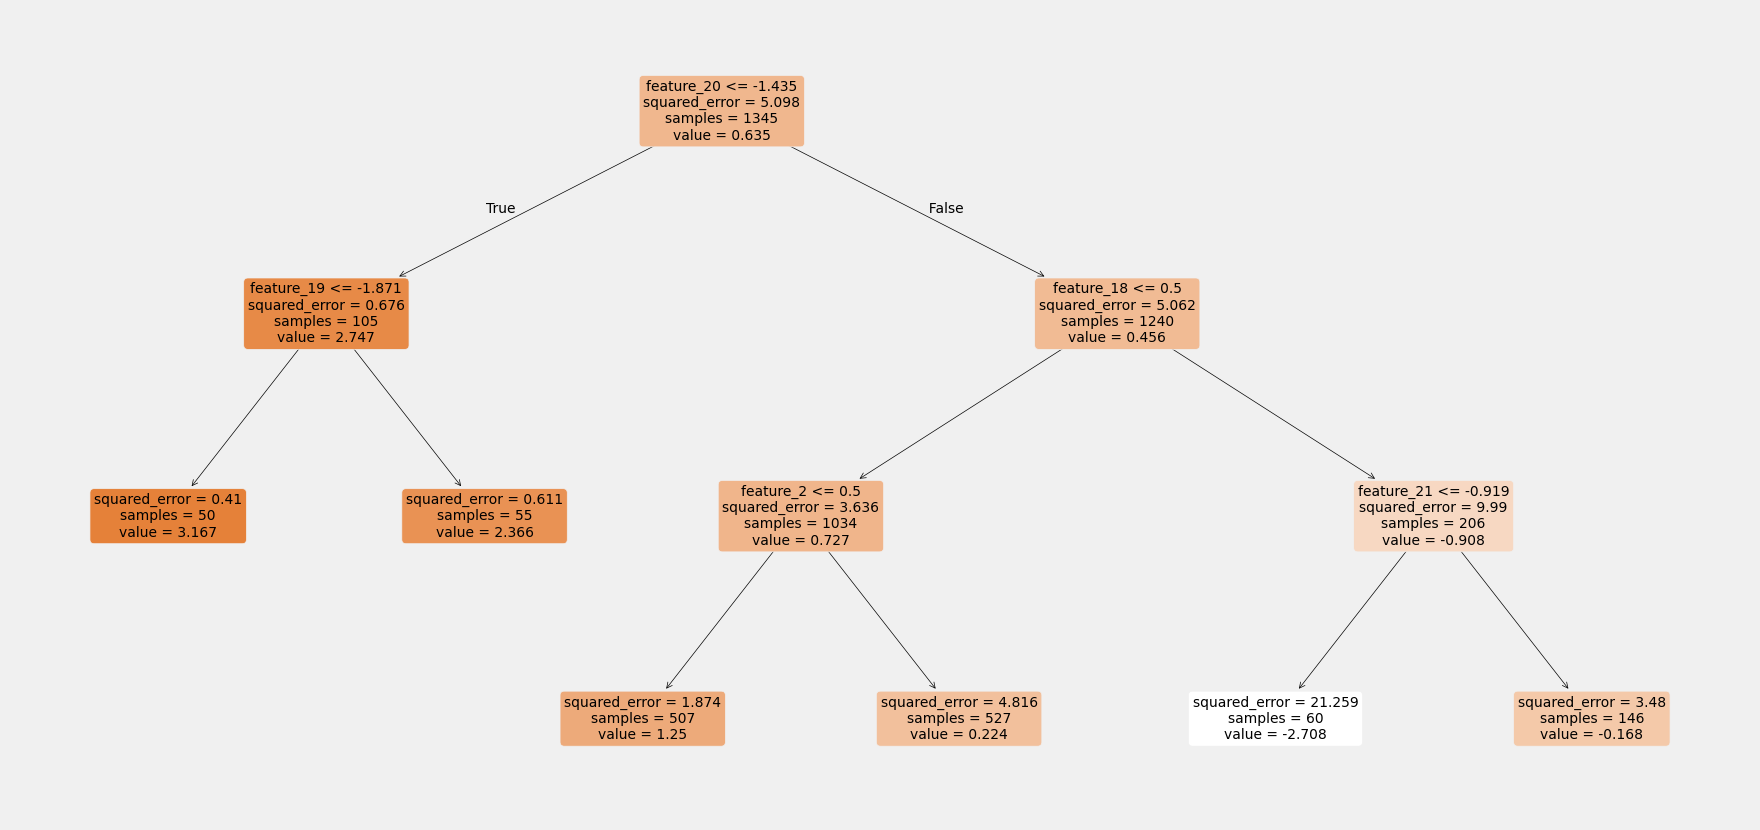

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# 1. 예측값 차이 계산
df_val['prediction_diff'] = df_val['dragonnet'] - df_val['s_learner']

# 2. 의사결정나무 모델 학습
# 특성(X)을 사용해 두 모델의 예측값 차이(prediction_diff)를 예측하도록 학습
tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=50)
tree.fit(X_val, df_val['prediction_diff'])

# 3. 트리 시각화 및 해석
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=[f'feature_{i}' for i in range(X_train_raw.shape[1])], filled=True, rounded=True, fontsize=10)
plt.show()


📊 요약된 패턴

- feature_20이 작은 경우 (≤ -1.435)
  → DragonNet이 S-learner보다 ITE를 더 크게 추정하는 구간이 존재 (특히 feature_19가 작을 때 +2~3 차이).

- feature_20이 크면서 feature_21도 작을 때 (≤ -0.919)
  → 반대로 DragonNet이 더 작게 추정 (약 -2.7 정도).

- 그 외 대부분 구간
  → 차이는 0 ~ +1 정도로 크지 않음.

In [ ]:
# # 'treatment' 변수 그룹별로 예측값 차이의 평균 확인
# print(df_val.groupby('treatment')['prediction_diff'].mean())

# # feature_6 (이진 변수 예시) 그룹별로 예측값 차이의 평균 확인
# # feature_6의 실제 의미를 안다면 더 유용한 분석이 가능합니다.
# print(df_val.groupby(1)['prediction_diff'].mean()) #

treatment
0    4.938123
1    4.463660
Name: prediction_diff, dtype: float64
1
0.0    4.847754
1.0    4.864259
Name: prediction_diff, dtype: float64


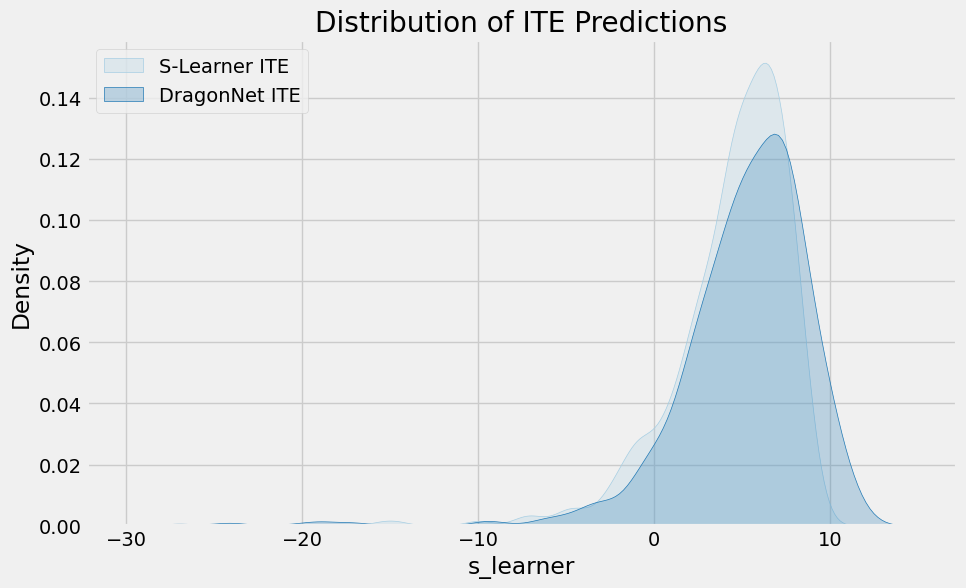

In [29]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(df_val['s_learner'], label='S-Learner ITE', fill=True)
sns.kdeplot(df_val['dragonnet'], label='DragonNet ITE', fill=True)
plt.title('Distribution of ITE Predictions')
plt.legend()
plt.show()

- 방향성: 두 모델 모두 "치료는 평균적으로 긍정적 효과"라고 본다.

- 차이점:

  - S-Learner: 효과를 조금 더 크게 본다 (낙관적).

  - DragonNet: 효과를 더 안정적·보수적으로 본다.

- 아웃라이어: 음수 구간 일부 있지만 분포 비중이 극히 작아 큰 의미는 없음.